In [6]:
'''
Antony Simonoff, Adam Fine. 2020
'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import random
import matplotlib
from warnings import warn
from tqdm import tqdm
from parameters_rlif_AS import par, update_dependencies, spikes_to_spikepulse

from utils_rlif_AS import EEG_wave
from excitability_funcs_AS import exc_diff_timedep_func, excitability_synaptic

T           = par['T']    # total time to simulate (ms)
dt          = par['simulation_dt'] # Simulation timestep
dts         = par['timesteps']
spikepulse_dts = par['num_spikepulse_timesteps']
spikepulse_func= spikes_to_spikepulse
spikepulse_profile = spikepulse_func(dt * np.arange(spikepulse_dts), par['voltage_decay_const'])
input_dts   = par['input_timesteps']
V_in        = par['V_in']   # Neuron input voltage
V_th        = par['V_th']
V_spike     = par['V_spike']
V_rest      = par['V_rest']
input_stdev = par['input_stdev']
voltage_stdev=par['voltage_stdev']

time_range = np.arange(0, T, dt)

num_layers  = par['num_layers']
num_neurons = par['num_neurons']
num_inputs  = par['num_inputs']
num_exc     = par['exc_num']

if par['set_seed'] != False:
    np.random.seed(par['set_seed'])

# choose neurotransmiters for each neuron
neurotransmitters = np.random.choice(par['neurotransmitters'], num_neurons, p = par['neuron_receptor_weights'])
connections_mult_matrix = np.ones(num_inputs + num_neurons)
for connection in np.arange(num_neurons):
    if neurotransmitters[connection] == 'GABA':
        connections_mult_matrix[connection] = par['inhib_weight']


# Calculate inputs
neuron_input = np.zeros((num_inputs, dts))
for input_neuron in np.arange(num_inputs):
    # Fixation, 300 ms
    neuron_input[input_neuron, :300] += EEG_wave(n_bins = 300, frequency = par['theta_wave_freq'], n_bin_offset = 0)

    # First input, 200 ms
    neuron_input[input_neuron, 300:500] += EEG_wave(n_bins = 200, frequency = par['theta_wave_freq'], n_bin_offset = 300)
    neuron_input[input_neuron, 300:500] += EEG_wave(n_bins = 200, frequency = par['input_1_freq'], n_bin_offset = 300)

    # Decay time, 500 ms
    neuron_input[input_neuron, 500:1000] += EEG_wave(n_bins = 500, frequency = par['theta_wave_freq'], n_bin_offset = 500)

    # Second input, 200 ms
    neuron_input[input_neuron, 1000:1200] += EEG_wave(n_bins = 200, frequency = par['theta_wave_freq'], n_bin_offset = 1000)
    neuron_input[input_neuron, 1000:1200] += EEG_wave(n_bins = 200, frequency = par['input_2_freq'], n_bin_offset = 1000)

    # End of trial, 800 ms
    neuron_input[input_neuron, 1200:2000] += EEG_wave(n_bins = 800, frequency = par['theta_wave_freq'], n_bin_offset = 1200)

# generation of connectivity arrays
def generate_connections(par):
    connections = np.zeros(num_inputs + num_neurons)
    input_yn = False
    yn_in = np.random.uniform()
    if yn_in < par['input_connect_binary_prob']:
        input_yn = True
        c_probs = np.random.uniform(size = num_inputs)
        for input in np.arange(c_probs.shape[0]):
            if c_probs[input] < par['input_connect_frac']:
                connections[input] = np.random.exponential(scale=.5)
    c_probs = np.random.uniform(size=num_neurons)
    for neuron in np.arange(c_probs.shape[0]):
        if c_probs[neuron] < par['recur_connect_frac']:
            connections[neuron+num_inputs] = np.random.uniform(.1, 1)
    connections = connections*connections_mult_matrix
    return connections, input_yn

# Basic LIF Neuron class
class LIFNeuron():
    def __init__(self, debug=True, **specific_params):
        # Simulation config (may not all be needed!!)
        self.dt       = par['simulation_dt']       # neuronal time step
        self.t_rest   = par['tau_ref']           # initial refractory time

        #LIF Properties
        self.gain     = specific_params.get('gain', par['gain'])      # neuron gain (unitless)
        self.t        = specific_params.get('t', 0)                   # neuron start time, can very between neurons
        self.Rm       = specific_params.get("Rm", par["Rm"])          # Resistance (kOhm)
        self.Cm       = specific_params.get("Cm", par["Cm"])          # Capacitance (uF)
        self.tau_m    = specific_params.get("tau_m", par["tau_m"])    # Time constant (ms)
        self.tau_ref  = specific_params.get("tau_ref", par["tau_ref"])# refractory period (ms)
        self.V_th     = specific_params.get("V_th", par["V_th"])      # spike threshold
        self.V_spike  = specific_params.get("V_spike", par["V_spike"])# spike delta (V)
        self.V_rest   = specific_params.get('V_rest', par['V_rest'])  # resting potential (V)
        self.type     = par['type']
        self.debug    = par['debug']
        self.exc_func = specific_params.get('exc_func', par['exc_func'])
        self.neuron_indx = specific_params.get('neuron_indx')
        self.connections, self.input_connected = generate_connections(par)
        self.neurotransmitter = specific_params.get('neurotransmitter', neurotransmitters[self.neuron_indx])

        self.input    = np.zeros(dts)
        self.output   = np.zeros(dts)
        self.exc      = np.zeros((4,dts)) # Resting potential (mV), threshold (mV), refractory period (ms), gain (unitless)
        self.V_m      = np.full(dts, self.V_rest)   # Neuron potential (mV)
        self.spikes   = np.zeros(dts)
        self.spiketimes = []
        self.exc[0, :] = self.V_rest
        self.exc[1, :] = self.V_th
        self.exc[2, :] = self.tau_ref
        self.exc[3, :] = self.gain
        if self.debug:
            print ('LIFNeuron(): Created {} neuron starting at time {}'.format(self.type, self.t))

    def spike_generator(self, input, timestep, neuron_number):
        if timestep*dt < par['tau_ref']:
            self.t_rest = 0
        if timestep*dt > self.t_rest:
            specific_input = np.sum(input*self.connections)
            self.input[timestep] = specific_input
            self.V_m[timestep] = self.V_m[timestep-1] + np.random.normal(0, voltage_stdev) +\
                (-self.V_m[timestep-1] + self.exc[0,timestep-1] + self.exc[3,timestep-1]*specific_input) / self.tau_m * self.dt
            self.exc[:, timestep] = self.exc_func(self.V_rest, self.V_th, self.tau_ref, self.gain,
                                      self.V_m[:timestep], self.spikes[:timestep], self.input[:timestep], self.exc[:,:timestep], self.neurotransmitter)

            if self.V_m[timestep] >= self.exc[1, timestep]:
                self.spikes[timestep] += self.V_spike
                try:
                    self.output[timestep:timestep + spikepulse_dts] += spikepulse_profile
                except:
                    if self.debug:
                        warn("self.output timestep ({}) out of current_profile range".format(timestep))
                    self.output[timestep:] += spikepulse_profile[:dts - timestep]
                self.spiketimes.append(timestep * dt)
                self.t_rest = timestep*dt + self.exc[2, timestep]
                self.V_m[timestep] = V_spike
                if self.debug:
                    print ('*** LIFNeuron.spike_generator.spike=(self.t_rest={}, self.t={}, self.tau_ref={})'.format(self.t_rest, self.t, self.tau_ref))
        else:
            self.exc[:, timestep] = self.exc_func(self.V_rest, self.V_th, self.tau_ref, self.gain,
                            self.V_m[:timestep], self.spikes[:timestep], self.input[:timestep], self.exc[:,:timestep], self.neurotransmitter)
            self.V_m[timestep] = self.exc[0, timestep]

# Create neuronal array
def create_neurons(num_layers, num_neurons, debug=False, **specific_params):
    neurons = []
    for layer in range(num_layers):
        if debug:
            print ('create_neurons(): Creating layer {}'.format(layer))
        neuron_layer = []
        for i in range(num_neurons):
            specific_params = {"neuron_indx": i, "exc_func": excitability_synaptic}
            neuron_layer.append(LIFNeuron(debug=debug, **specific_params))
        neurons.append(neuron_layer)
    return neurons

--> Loading parameters...
--> Parameters loaded successfully


In [7]:
neurons = create_neurons(num_layers, num_neurons, debug=False, exc_func = excitability_synaptic)
num_input_connected_neurons = np.sum([neurons[0][neuron].input_connected for neuron in np.arange(num_neurons)])

full_input = np.zeros((num_inputs + num_neurons, dts))
full_input[:num_inputs, :] = neuron_input
for timestep in tqdm(np.arange(1, dts), desc="Calculating RNN spikes per timestep"):
    for neuron in np.arange(num_neurons):
        full_input[num_inputs+neuron, timestep] = neurons[0][neuron].output[timestep-1]
    for neuron in np.arange(num_neurons):
        neurons[0][neuron].spike_generator(full_input[:, timestep], timestep, neuron)

Calculating RNN spikes per timestep: 100%|█████████████████████████████████████████| 1999/1999 [00:32<00:00, 62.04it/s]


In [8]:
full_output = np.zeros((num_neurons, dts))
for neuron in np.arange(num_neurons):
    full_output[neuron, :] = neurons[0][neuron].V_m

41 29 30


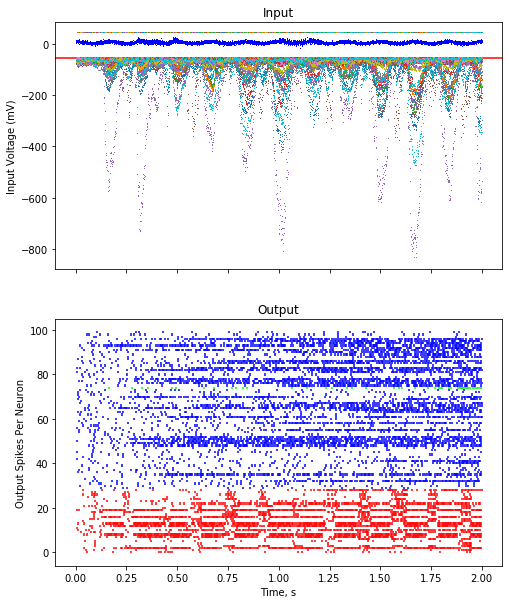

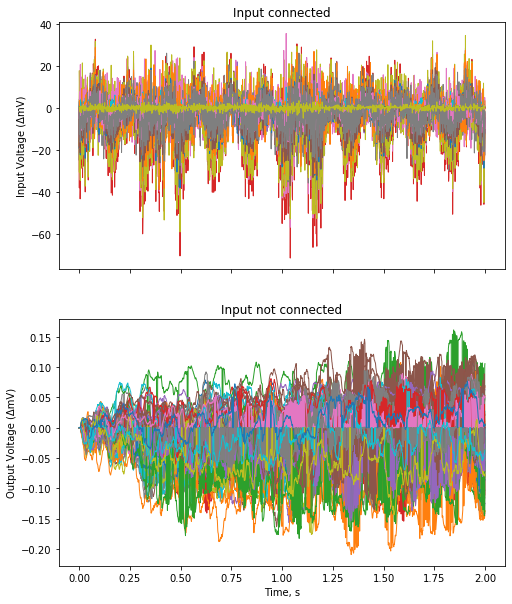

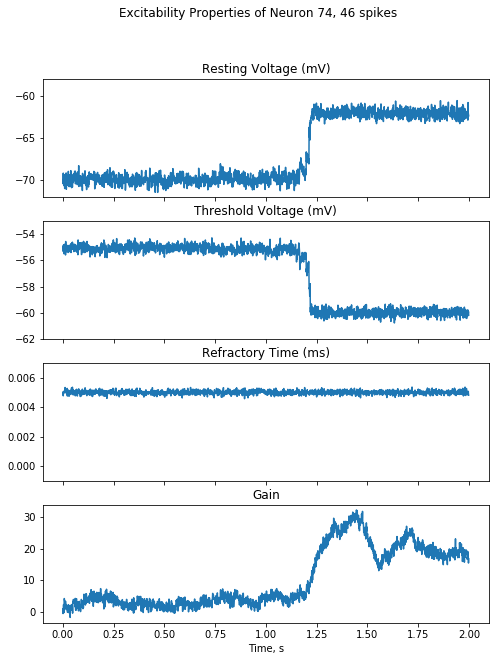

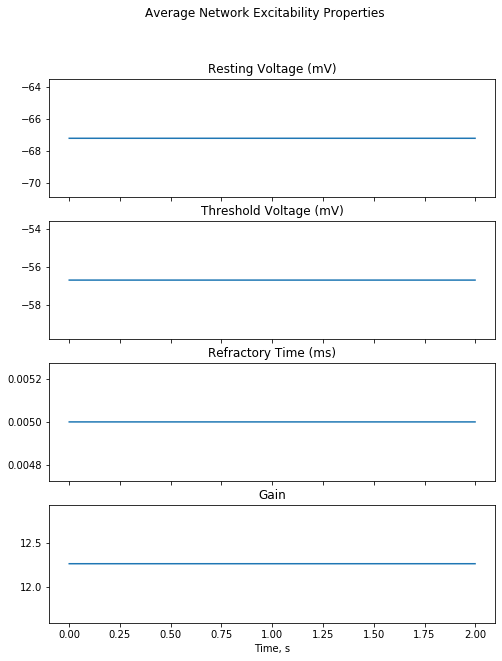

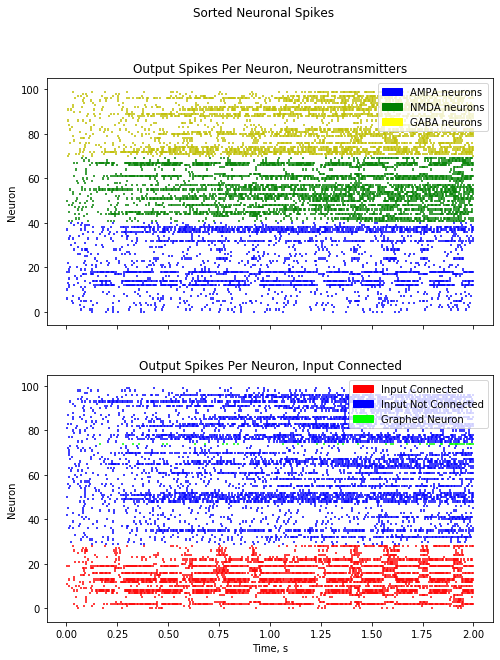

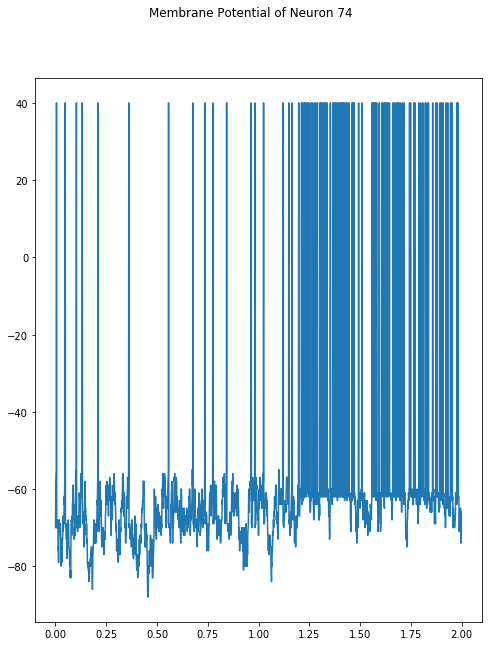

In [17]:
figsize = [8, 10]

fig, axs = plt.subplots(2,1, sharex=True, figsize = figsize)
for input_num in np.arange(num_inputs):
    axs[0].plot(time_range, full_input[input_num, :], 'b,')
axs[0].axhline(par['V_th'], color='r')
for output_num in np.arange(num_neurons):
    axs[0].plot(time_range, neurons[0][output_num].V_m, ',')

graphed_neuron = np.random.choice(np.arange(num_input_connected_neurons, num_neurons))
# graphed_neuron = 93
neuron_spiketimes = [neurons[0][neuron].spiketimes for neuron in np.arange(num_neurons)]
neuron_input_connections = [neurons[0][neuron].input_connected for neuron in np.arange(num_neurons)]
sorted_neuron_spiketimes = [spiketime for spiketime, tf in sorted(zip(neuron_spiketimes, neuron_input_connections), key=lambda neuron: neuron[1], reverse=True)]

# tau_ref_min = [min(neurons[0][neuron].exc[2, :]) for neuron in np.arange(num_neurons)]
# print(tau_ref_min)
# print(min(tau_ref_min))
# plt.plot(tau_ref_min)

neuron_colors = ['b'] * num_neurons
neuron_colors[:num_input_connected_neurons] = ['r']*num_input_connected_neurons
neuron_colors[graphed_neuron] = 'lime'
axs[1].eventplot(sorted_neuron_spiketimes, colors=neuron_colors)
axs[0].set_ylabel("Input Voltage (mV)")
axs[1].set_ylabel("Output Spikes Per Neuron")
axs[1].set_xlabel("Time, s")
axs[0].set_title('Input')
axs[1].set_title('Output')

fig2, axs2 = plt.subplots(2,1, sharex=True, figsize = figsize)
for neuron_num in np.arange(num_neurons):
    if neurons[0][neuron_num].input_connected:
        axs2[0].plot(time_range, neurons[0][neuron_num].input, linewidth=1)
    else:
        axs2[1].plot(time_range, neurons[0][neuron_num].input, linewidth=1)
axs2[0].set_ylabel("Input Voltage (\u0394mV)")
axs2[1].set_ylabel("Output Voltage (\u0394mV)")
axs2[1].set_xlabel("Time, s")
axs2[0].set_title('Input connected')
axs2[1].set_title('Input not connected')

fig3, axs3 = plt.subplots(4,1, sharex=True, figsize = figsize)
exc_labels = ["Resting Voltage (mV)", "Threshold Voltage (mV)", "Refractory Time (ms)", "Gain"]
for exc_prop in np.arange(4):
    axs3[exc_prop].plot(time_range, neurons[0][graphed_neuron].exc[exc_prop, :])
    axs3[exc_prop].set_title(exc_labels[exc_prop])
axs3[0].set_ylim([V_rest - 2, par['exc_rest_max'] + 2])
axs3[1].set_ylim([par['exc_thresh_min'] - 2, V_th + 2])
axs3[2].set_ylim([par['tau_abs_ref'] - 0.002, par['tau_ref'] + 0.002])
axs3[3].set_xlabel("Time, s")
fig3.suptitle('Excitability Properties of Neuron {}, {} spikes'.format(graphed_neuron, np.shape(sorted_neuron_spiketimes[graphed_neuron])[0]))

fig4, axs4 = plt.subplots(4, 1, sharex=True, figsize = figsize)
exc_avg = np.zeros((4, dts))
for exc_prop in np.arange(4):
    exc_avg[exc_prop, :] = np.mean([neuron.exc[exc_prop, :] for neuron in neurons[0]])
    axs4[exc_prop].plot(time_range, exc_avg[exc_prop, :])
    axs4[exc_prop].set_title(exc_labels[exc_prop])
axs4[3].set_xlabel("Time, s")
fig4.suptitle('Average Network Excitability Properties')

fig5, axs5 = plt.subplots(2, 1, sharex=True, figsize = figsize)
sorted_neurotransmitter_spiketimes = [spiketime for spiketime, tf in sorted(zip(neuron_spiketimes, neurotransmitters), key=lambda neuron: neuron[1], reverse=True)]
num_AMPA = np.count_nonzero(neurotransmitters == "AMPA")
num_NMDA = np.count_nonzero(neurotransmitters == "NMDA")
num_GABA = np.count_nonzero(neurotransmitters == "GABA")
neurotransmitter_colors = ['y'] * num_neurons
neurotransmitter_colors[:num_AMPA] = ['b'] * num_AMPA
neurotransmitter_colors[num_AMPA:num_NMDA + num_AMPA] = ['g'] * num_NMDA
neurotransmitter_colors[num_NMDA + num_AMPA:] = ['y'] * num_GABA
print(num_AMPA, num_NMDA, num_GABA)

axs5[0].eventplot(sorted_neurotransmitter_spiketimes, colors = neurotransmitter_colors)
AMPA_patch = mpatches.Patch(color='blue', label='AMPA neurons')
NMDA_patch = mpatches.Patch(color='green', label='NMDA neurons')
GABA_patch = mpatches.Patch(color='yellow', label='GABA neurons')
axs5[0].legend(handles = [AMPA_patch, NMDA_patch, GABA_patch], loc = 'upper right')


axs5[1].set_xlabel("Time, s")
axs5[1].eventplot(sorted_neuron_spiketimes, colors=neuron_colors)
input_connected_patch = mpatches.Patch(color='red', label='Input Connected')
input_not_connected_patch = mpatches.Patch(color='blue', label='Input Not Connected')
graphed_neuron_patch = mpatches.Patch(color='lime', label='Graphed Neuron')
axs5[1].legend(handles = [input_connected_patch, input_not_connected_patch, graphed_neuron_patch], loc = 'upper right')


axs5[0].set_ylabel("Neuron")
axs5[1].set_ylabel("Neuron")
axs5[1].set_xlabel("Time, s")
axs5[0].set_title('Output Spikes Per Neuron, Neurotransmitters')
axs5[1].set_title('Output Spikes Per Neuron, Input Connected')
fig5.suptitle('Sorted Neuronal Spikes')

fig6, axs6 = plt.subplots(1, 1, sharex=True, figsize = figsize)
axs6.plot(time_range, neurons[0][graphed_neuron].V_m)
fig6.suptitle('Membrane Potential of Neuron {}'.format(graphed_neuron))

plt.show()

# TODO: make legends
# fix input voltage going down to -800 or explain